In [1]:
import mujoco
import jax
import brax
from jax import numpy as jp
from matplotlib import rc
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from brax.io import mjcf
import mediapy as media
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
rc('animation', html='jshtml')
%env MUJOCO_GL=egl

tpu
env: MUJOCO_GL=egl


In [5]:
path = f'env/panda.xml'
# mj = mujoco.MjModel.from_xml_path(path)
# sys = mjcf.load_model(mj)
sys = mjcf.load(path)

In [6]:
sys.q_size(), sys.init_q.shape[0], sys.qd_size()

(14, 14, 13)

In [7]:
sys.num_links(), sys.link_types, len(sys.link_types)

(8, 'f1111111', 8)

In [10]:
list(zip(sys.link_names, sys.link_parents, sys.link_types, sys.dof_ranges()))

[('link0', -1, 'f', [0, 1, 2, 3, 4, 5]),
 ('link1', 0, '1', [6]),
 ('link2', 1, '1', [7]),
 ('link3', 2, '1', [8]),
 ('link4', 3, '1', [9]),
 ('link5', 4, '1', [10]),
 ('link6', 5, '1', [11]),
 ('link7', 6, '1', [12])]

### Visualize the model

In [12]:
from brax.generalized import pipeline
from brax import kinematics

q = sys.init_q
qd = jp.zeros(sys.qd_size())
x, xd = kinematics.forward(sys, q, qd)
state = jax.jit(pipeline.init)(sys, q, qd)

In [13]:
state.x.pos.all() == x.pos.all(), x.pos.shape

(Array(True, dtype=bool), (8, 3))

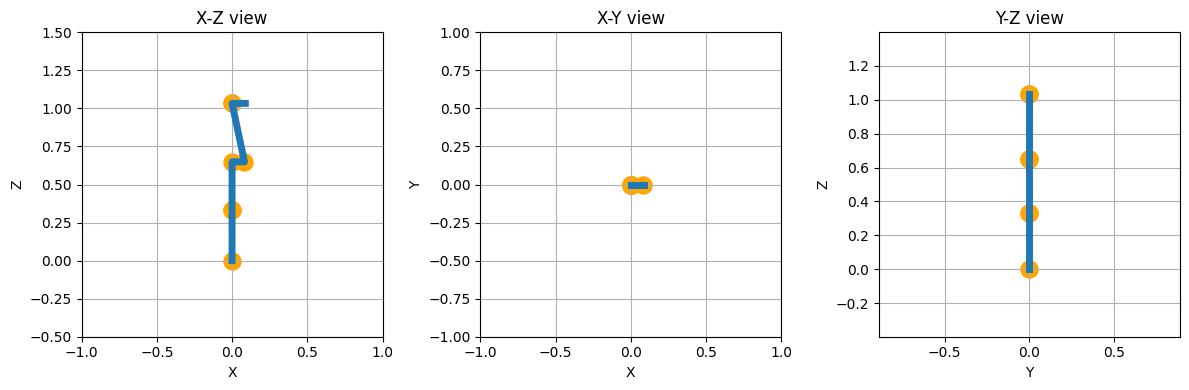

In [14]:
def visualize(axes, pos, alpha=1):
    assert axes.shape == (3,)
    x_arm = jp.vstack([jp.zeros((1,3)), pos[:8]])
    joint_names = ['jnt-1', 'jnt-2', 'jnt-3', 'jnt-4', 'jnt-5', 'jnt-6', 'jnt-7']
    title = ['X-Z view', 'X-Y view', 'Y-Z view']
    xlim = [(-1, 1), (-1, 1), (-1, 1)]
    ylim = [(-0.5, 1.5), (-1, 1), (-0.5, 1.5)]
    for i in range(3):
        axes[i].plot(x_arm[:, i//2], x_arm[:, 2-i%2], linewidth=5, label='Arm', alpha=alpha)
        # axes[i].plot(pos[7:-1, i//2], pos[7:-1, 2-i%2], linewidth=3, color='gray', label='Whip', alpha=alpha)
        # axes[i].scatter(pos[-1, i//2], pos[-1, 2-i%2], s=300, c='gray', edgecolors='black', label='Target', alpha=alpha)
        axes[i].scatter(pos[:7, i//2], pos[:7, 2-i%2], s=150, c='orange', edgecolors='face', label='Joint')
        axes[i].grid()
        axes[i].set_title(title[i])
        axes[i].set_xlabel(title[i][0:1])
        axes[i].set_ylabel(title[i][2:3])
        axes[i].set_xlim(*xlim[i])
        axes[i].set_ylim(*ylim[i])
    legend = axes[-1].legend(['Arm'], loc='upper right', title='Components', bbox_to_anchor=(1.4, 1))
    axes[-1].add_artist(legend)

_, axes = plt.subplots(1,3, figsize=(12, 4))
plt.axis ('equal')
visualize(axes, x.pos, alpha=1)
plt.tight_layout()

### Update Model

In [15]:
from brax import actuator
from brax import geometry
from brax import kinematics
from brax.base import System
from brax.generalized import constraint
from brax.generalized import dynamics
from brax.generalized import integrator
from brax.generalized import mass
from brax.generalized.base import State

In [25]:
act = jp.array([0, 0, 0, -1.57079, 0, 1.57079, -0.7853])

q = sys.init_q
qd = jp.zeros(sys.qd_size())
state = jax.jit(pipeline.init)(sys, q, qd)

In [26]:
xpos = []
for i in range(300):
    state = jax.jit(pipeline.step)(sys, state, act)
    xpos.append(state.x.pos)

In [29]:
xpos = jp.array(xpos)
xpos.shape

(300, 8, 3)

Animation

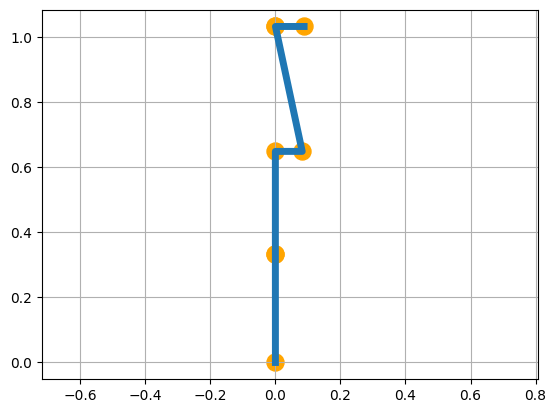

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib.patches import Circle
from matplotlib import rc
rc('animation', html='jshtml')

fig, ax = plt.subplots()
plt.xlim([-1, 1])
plt.ylim([-0.5, 1.5])
plt.axis ('equal')
ax.grid()

n = len(xpos)
line, = ax.plot(xpos[0, :, 0], xpos[0, :, 2], linewidth=5)
scat = ax.scatter(xpos[0, :, 0], xpos[0, :, 2], s=150, c='orange', edgecolors='face')
plt.show()

def init():
    return line,

def animate(i):
    x, z = xpos[i, :, 0], xpos[i, :, 2]
    line.set_data(x, z)
    scat.set_offsets(jp.vstack([x, z]).T)
    return line, 

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n, interval=20, blit=False, repeat=True)
plt.close() 

In [44]:
anim.save("figure/panda.gif")

step

In [ ]:
tau = actuator.to_tau(sys, act, state.q, state.qd)
state = state.replace(qf_smooth=dynamics.forward(sys, state, tau))
state = state.replace(qf_constraint=constraint.force(sys, state))

# update position/velocity level terms
state = integrator.integrate(sys, state)
x, xd = kinematics.forward(sys, state.q, state.qd)
state = state.replace(x=x, xd=xd)
state = dynamics.transform_com(sys, state)
state = mass.matrix_inv(sys, state, sys.matrix_inv_iterations)
state = constraint.jacobian(sys, state)

In [16]:
state = jax.jit(pipeline.step)(sys, state, ctrl)

In [17]:
state.x.pos[-1,:]

Array([nan, nan, nan], dtype=float32)

In [25]:
force_range = jp.array([[-87, 87 ]]*4 + [[-12, 12]]*3)
ctrl_range = jp.array([[-2.8973,  2.8973], [-1.7628,  1.7628], [-2.8973,  2.8973], [-3.0718, -0.0698], [-2.8973,  2.8973], [-0.0175,  3.7525], [-2.8973,  2.8973]])
sys.actuator.replace(ctrl_range=ctrl_range)

Actuator(q_id=Array([0, 1, 2, 3, 4, 5, 6], dtype=int32), qd_id=Array([0, 1, 2, 3, 4, 5, 6], dtype=int32), ctrl_range=Array([[-2.8973,  2.8973],
       [-1.7628,  1.7628],
       [-2.8973,  2.8973],
       [-3.0718, -0.0698],
       [-2.8973,  2.8973],
       [-0.0175,  3.7525],
       [-2.8973,  2.8973]], dtype=float32), gear=Array([1., 1., 1., 1., 1., 1., 1.], dtype=float32), bias_q=Array([-4500., -4500., -3500., -3500., -2000., -2000., -2000.], dtype=float32), bias_qd=Array([-450., -450., -350., -350., -200., -200., -200.], dtype=float32))

In [16]:
sys.actuator.ctrl_range

Array([[-2.8973,  2.8973],
       [-1.7628,  1.7628],
       [-2.8973,  2.8973],
       [-3.0718, -0.0698],
       [-2.8973,  2.8973],
       [-0.0175,  3.7525],
       [-2.8973,  2.8973]], dtype=float32)

In [21]:
sys.actuator.__dict__.keys()

dict_keys(['q_id', 'qd_id', 'ctrl_range', 'gear', 'bias_q', 'bias_qd'])

In [127]:
x.pos.shape, xd.ang.shape

((36, 3), (36, 3))

[[-87, 87], [-87, 87], [-87, 87], [-87, 87], [-12, 12], [-12, 12], [-12, 12]]